# 编程练习5：正则化线性回归的偏差与方差
虽然名字起得怪怪的，但这一章主要是讲机器学习算法的诊断。  
我们在ex1里自己实现了一遍线性回归，这次我们看看直接使用scikit-learn自带的正则化线性回归。  
## 1 正则化线性回归
这次的问题是研究水位和水坝溢水量的关系。  
### 1.1 数据集可视化

In [103]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, scale

In [72]:
raw_data = loadmat('ex5data1.mat')
X = np.mat(raw_data['X'])
y = np.mat(raw_data['y'])
Xval = np.mat(raw_data['Xval'])
yval = np.mat(raw_data['yval'])
Xtest = np.mat(raw_data['Xtest'])
ytest = np.mat(raw_data['ytest'])

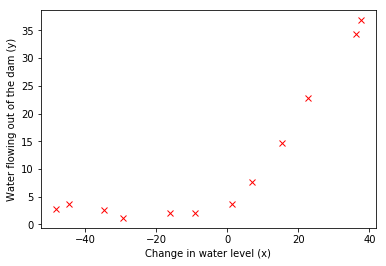

In [53]:
plt.plot(X, y, 'rx')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

### 1.4 拟合线性回归

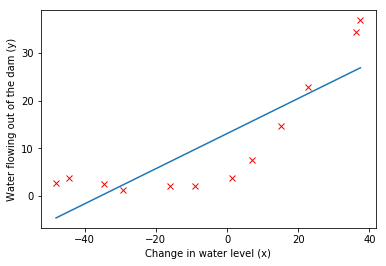

In [19]:
lr = LinearRegression()
lr.fit(X,y)
xdata = [np.min(X), np.max(X)]
ydata = [lr.predict(xd)[0,0] for xd in xdata]
plt.plot(xdata, ydata)
plt.plot(X, y, 'rx')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

## 2偏差与方差
### 2.1 学习曲线
ex5中，是使用代价函数来绘制学习曲线。代价函数我们已经实现过很多次了，这次看看直接使用scikit-learn的评分函数来绘制学习曲线。  
另外，正则化线性回归在scikit-learn中叫岭回归，我们一并试一下。

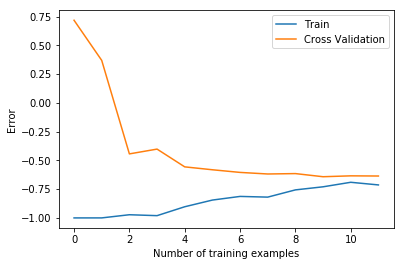

In [27]:
error_train = []
error_val = []
rr = Ridge(alpha=1.0)
for i in range(1, len(X)+1):
    Xtrain = X[0:i]
    ytrain = y[0:i]
    rr.fit(Xtrain, ytrain)
    error_train.append(-rr.score(Xtrain, ytrain))
    error_val.append(-rr.score(Xval, yval))
plt.plot(error_train, label='Train')
plt.plot(error_val, label='Cross Validation')
plt.legend()
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.show()

## 3 多项式回归
### 3.1 多项式回归参数学习
我们为X添加最高8次的多项式，观察拟合结果。  
标准换StandardScaler的使用要特别注意，参见http://blog.csdn.net/mvpboss1004/article/details/79249142  
最后就是，我发现设lambda=0无论如何得不出教材中的结果，只能设置为一个相对较小的值。目前还没找到原因。

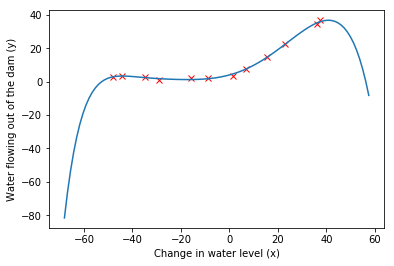

In [160]:
class NormPoly:
    def __init__(self, degree=8):
        self._pf = PolynomialFeatures(degree, include_bias=False)
        self._ss = StandardScaler()
    def fit(self, X):
        self._pf.fit(X)
        X_poly = self._pf.transform(X)
        self._ss.mean_ = np.mean(X_poly, axis=0)
        self._ss.scale_ = np.std(X_poly, axis=0, ddof=1)
    def transform(self, X):
        return self._ss.transform(self._pf.transform(X))
nper = NormPoly()
nper.fit(X)
X_norm = nper.transform(X)
rr = Ridge(alpha=0.003, normalize=False)
rr.fit(X_norm, y)
plt.plot(X, y, 'rx')
xdata = np.mat(np.linspace(np.min(X)-20, np.max(X)+20, 100)).reshape((100,1))
plt.plot(xdata, rr.predict(nper.transform(xdata)))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

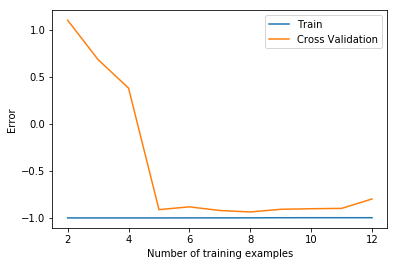

In [162]:
error_train = []
error_val = []
rg = range(2,len(X)+1)
for i in rg:
    nper.fit(X[0:i])
    ytrain = y[0:i]
    Xnorm = nper.transform(X[0:i])
    rr.fit(Xnorm, ytrain)
    error_train.append(-rr.score(Xnorm, ytrain))
    error_val.append(-rr.score(nper.transform(Xval), yval))
plt.plot(rg, error_train, label='Train')
plt.plot(rg, error_val, label='Cross Validation')
plt.legend()
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.show()

### 3.3 通过交叉验证集选择lambda
选择不同的lamda，当训练集的代价曲线与交叉验证集的代价曲线相交时，就是最佳lambda。

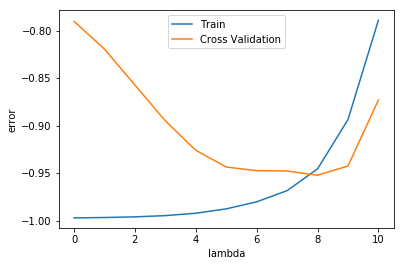

In [170]:
error_train = []
error_val = []
nper.fit(X)
Xnorm = nper.transform(X)
Xnormv = nper.transform(Xval)
lamdas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]
for lamda in lamdas:
    lrr = Ridge(alpha=lamda, normalize=False)
    lrr.fit(Xnorm, y)
    error_train.append(-lrr.score(Xnorm, y))
    error_val.append(-lrr.score(Xnormv, yval))
plt.plot(error_train, label='Train')
plt.plot(error_val, label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('error')
plt.show()